In this notebook, I'll explore several common regularization techniques, and use them to improve on a classification model.

## Setup

In [1]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

print(tf.__version__)

2.19.0


In [2]:
!pip install git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

  Cloning https://github.com/tensorflow/docs to c:\users\mehri\appdata\local\temp\pip-req-build-mk2pf6dy
  Resolved https://github.com/tensorflow/docs to commit a8576cef38b7182e6228d7aafca8ef51754ab9e8
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2025.3.6.10029-py3-none-any.whl size=187793 sha256=0e6e608693ab0f7694f7461986608c9d4cabbdb95080c84cdecfe918ae78ae7c
  Stored in directory: C:\Users\mehri\AppData\Local\Temp\pip-ephem-wheel-cache-b_om1u9w\wheels\3e\88\34\48d2789bc9d37b33ddce06bccc454fae0285e5396d0a5be9d9
Successfully built tensorflow-docs


  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs 'C:\Users\mehri\AppData\Local\Temp\pip-req-build-mk2pf6dy'

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
from  IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile

In [108]:
logdir ="./tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

### Loading the date set

It contains 11,000,000 examples, each with 28 features, and a binary class label.

In [5]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

2816407858/2816407858 ━━━━━━━━━━━━━━━━━━━━ 3244s 1us/step


In [41]:
FEATURES = 28

In [42]:
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1), compression_type="GZIP")

The following function repacks that list of scalars into a (feature_vector, label) pair.

In [43]:
def pack_row(*row):
  label = row[0]
  features = tf.stack(row[1:],1)
  return features, label

TensorFlow is most efficient when operating on large batches of data.

So, instead of repacking each row individually make a new tf.data.Dataset that takes batches of 10,000 examples, applies the pack_row function to each batch, and then splits the batches back up into individual records:

In [44]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

Inspect some of the records from this new packed_ds.

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


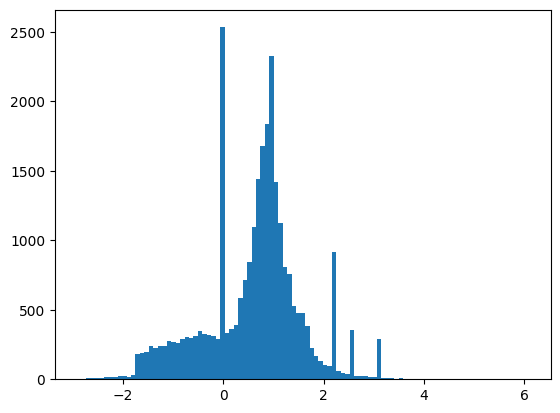

In [45]:
for features,label in packed_ds.batch(1000).take(1):
  print(features[0])
  plt.hist(features.numpy().flatten(), bins = 101)

due to hardware insufficiency and lack of time ;I'll use just the first 1,000 samples for validation, and the next 10,000 for training:

## Split and Prepare

In [57]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

In [58]:
dataset = packed_ds.shuffle(BUFFER_SIZE)
validate_ds = dataset.take(N_VALIDATION).cache()
train_ds = dataset.skip(N_VALIDATION).take(N_TRAIN).cache()

In [59]:
train_ds

<CacheDataset element_spec=(TensorSpec(shape=(28,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

### Expand, Batch, and Align Labels
Map a function over train_ds and validate_ds to insert the singleton channel dimension, turning (batch, FEATURES) → (batch, FEATURES, 1):

this helps to get over with tensorflow's issue in its recent upgrade .

In [60]:
def add_channel_and_label(x, y):
    # x: (FEATURES,) -> (FEATURES, 1)
    x = tf.expand_dims(x, axis=-1)
    # y: scalar -> (1,) to match model output
    y = tf.expand_dims(y, axis=-1)
    return x, y

# Apply mapping, batching, and prefetching
train_ds = (
    train_ds
    .map(add_channel_and_label, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)
validate_ds = (
    validate_ds
    .map(add_channel_and_label, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

**The simplest way to prevent overfitting is to start with a small model**

## Training Procedure

**Many models train better if we gradually reduce the learning rate during training**

The following code sets a `tf.keras.optimizers.schedules.InverseTimeDecay` to hyperbolically decrease the learning rate to 1/2 of the base rate at 1,000 epochs, 1/3 at 2,000 epochs, and so on.

### Learning Rate Schedule and Callbacks

In [61]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

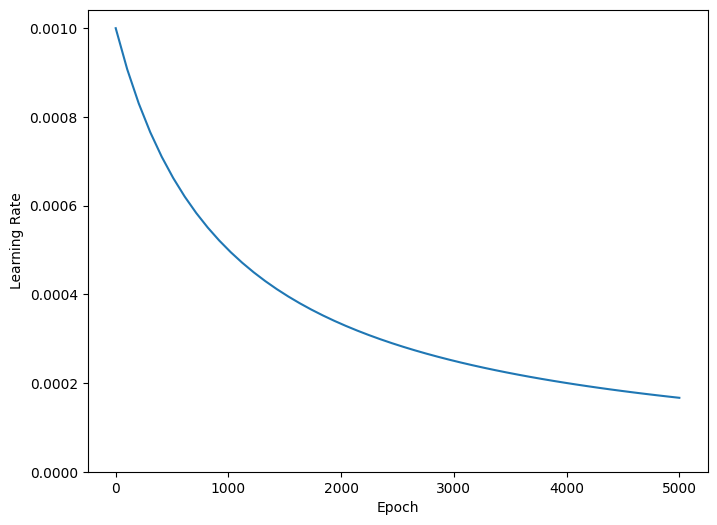

In [62]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

#### Call backs
* using the tfdocs.EpochDots which simply prints a `.` for each epoch, and a full set of metrics every 100 epochs,
To reduce the logging noise .

*  include `tf.keras.callbacks.EarlyStopping` to **avoid** long and unnecessary training times.
>  this callback is set to monitor the `val_binary_crossentropy`, not the `val_loss`.

* Use `callbacks.TensorBoard` to generate TensorBoard logs for the training.

In [ ]:
def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]

### Compile and fit function

In [63]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
    if optimizer is None:
        optimizer = get_optimizer()
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=[
            tf.keras.metrics.BinaryCrossentropy(
                from_logits=True, name='binary_crossentropy'),
            'accuracy'
        ]
    )
    model.summary()
    history = model.fit(
        train_ds,
        steps_per_epoch=STEPS_PER_EPOCH,
        epochs=max_epochs,
        validation_data=validate_ds,
        callbacks=get_callbacks(name),
        verbose=0
    )
    return history

### Tiny Model

the simplest way to avoid overfitting is to use a low capacity model.

In [64]:
tiny_model = tf.keras.Sequential([
    layers.Flatten(input_shape=(FEATURES, 1)),
    layers.Dense(16, activation='elu'),
    layers.Dense(1)
])

c:\Users\mehri\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [65]:
size_histories = {}

In [66]:
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 28)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 481 (1.88 KB)

 Trainable params: 481 (1.88 KB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, accuracy:0.5046,  binary_crossentropy:0.7621,  loss:0.7621,  val_accuracy:0.5040,  val_binary_crossentropy:0.7506,  val_loss:0.7506,  
..

c:\Users\mehri\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


..................................................................................................
Epoch: 100, accuracy:0.5911,  binary_crossentropy:0.6325,  loss:0.6325,  val_accuracy:0.5850,  val_binary_crossentropy:0.6442,  val_loss:0.6442,  
....................................................................................................
Epoch: 200, accuracy:0.6148,  binary_crossentropy:0.6209,  loss:0.6209,  val_accuracy:0.6000,  val_binary_crossentropy:0.6363,  val_loss:0.6363,  
....................................................................................................
Epoch: 300, accuracy:0.6263,  binary_crossentropy:0.6135,  loss:0.6135,  val_accuracy:0.6120,  val_binary_crossentropy:0.6314,  val_loss:0.6314,  
....................................................................................................
Epoch: 400, accuracy:0.6358,  binary_crossentropy:0.6082,  loss:0.6082,  val_accuracy:0.6200,  val_binary_crossentropy:0.6280,  val_loss:0.6280,  
..........

(0.0, 0.7)

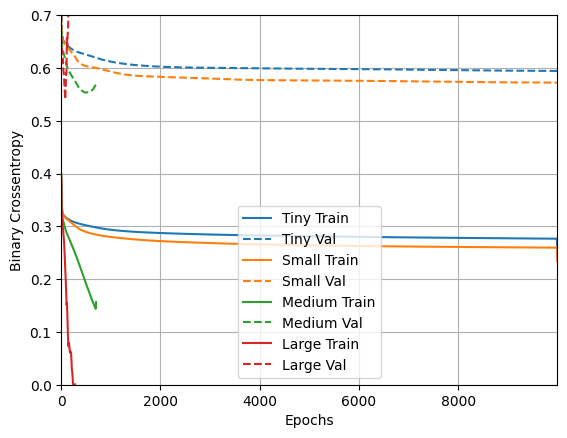

In [103]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.0, 0.7])

### Small model
To check if you can beat the performance of the small model, progressively train some larger models.



In [68]:
small_model = tf.keras.Sequential([
    layers.Flatten(input_shape=(FEATURES, 1)),
    layers.Dense(16, activation='elu'),
    layers.Dense(16, activation='elu'),
    layers.Dense(1)
])

In [69]:
size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small')

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)             │ (None, 28)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 16)             │           464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 753 (2.94 KB)

 Trainable params: 753 (2.94 KB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, accuracy:0.4726,  binary_crossentropy:0.7606,  loss:0.7606,  val_accuracy:0.4870,  val_binary_crossentropy:0.7137,  val_loss:0.7137,  
....................................................................................................
Epoch: 100, accuracy:0.5913,  binary_crossentropy:0.6297,  loss:0.6297,  val_accuracy:0.5830,  val_binary_crossentropy:0.6415,  val_loss:0.6415,  
....................................................................................................
Epoch: 200, accuracy:0.6189,  binary_crossentropy:0.6141,  loss:0.6141,  val_accuracy:0.6060,  val_binary_crossentropy:0.6305,  val_loss:0.6305,  
....................................................................................................
Epoch: 300, accuracy:0.6469,  binary_crossentropy:0.5984,  loss:0.5984,  val_accuracy:0.6230,  val_binary_crossentropy:0.6175,  val_loss:0.6175,  
....................................................................................................
Epoch: 40

### Medium model

Now try three hidden layers with 64 units each:

In [75]:
medium_model = tf.keras.Sequential([
    layers.Flatten(input_shape=(FEATURES, 1)),
    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(1)
])

In [76]:
# And train the model using the same data:

size_histories['Medium']  = compile_and_fit(medium_model, "sizes/Medium")

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_6 (Flatten)             │ (None, 28)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 64)             │         1,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,241 (40.00 KB)

 Trainable params: 10,241 (40.00 KB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, accuracy:0.4872,  binary_crossentropy:0.7244,  loss:0.7244,  val_accuracy:0.4760,  val_binary_crossentropy:0.6887,  val_loss:0.6887,  
....................................................................................................
Epoch: 100, accuracy:0.6763,  binary_crossentropy:0.5798,  loss:0.5798,  val_accuracy:0.6500,  val_binary_crossentropy:0.6078,  val_loss:0.6078,  
....................................................................................................
Epoch: 200, accuracy:0.7159,  binary_crossentropy:0.5346,  loss:0.5346,  val_accuracy:0.6690,  val_binary_crossentropy:0.5864,  val_loss:0.5864,  
....................................................................................................
Epoch: 300, accuracy:0.7501,  binary_crossentropy:0.4877,  loss:0.4877,  val_accuracy:0.6890,  val_binary_crossentropy:0.5709,  val_loss:0.5709,  
....................................................................................................
Epoch: 40

### Large model

creating an even larger model and check how quickly it begins overfitting.

In [73]:
large_model = tf.keras.Sequential([
    layers.Flatten(input_shape=(FEATURES, 1)),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1)
])

In [74]:
size_histories['large'] = compile_and_fit(large_model, "sizes/large")

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_5 (Flatten)             │ (None, 28)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 512)            │        14,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 803,329 (3.06 MB)

 Trainable params: 803,329 (3.06 MB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, accuracy:0.4969,  binary_crossentropy:0.7823,  loss:0.7823,  val_accuracy:0.5280,  val_binary_crossentropy:0.6724,  val_loss:0.6724,  
....................................................................................................
Epoch: 100, accuracy:0.8471,  binary_crossentropy:0.3312,  loss:0.3312,  val_accuracy:0.7300,  val_binary_crossentropy:0.6180,  val_loss:0.6180,  
....................................................................................................
Epoch: 200, accuracy:0.9514,  binary_crossentropy:0.1164,  loss:0.1164,  val_accuracy:0.7960,  val_binary_crossentropy:0.8606,  val_loss:0.8606,  
.................................................................................

## Plot the training and validation losses

The solid lines show the training loss, and the dashed lines show the validation loss (remember: a lower validation loss indicates a better model)

While building a larger model gives it more power, if this power is not constrained somehow it can easily overfit to the training set.

* It's normal for there to be a small difference.
* If both metrics are moving in the same direction, everything is fine.
* If the validation metric begins to stagnate while the training metric continues to improve, you are probably close to overfitting.
* If the validation metric is going in the wrong direction, the model is clearly overfitting.

In [78]:
print(size_histories)

{'Tiny': <keras.src.callbacks.history.History object at 0x00000173739F49B0>, 'Small': <keras.src.callbacks.history.History object at 0x00000173741ACE60>, 'Medium': <keras.src.callbacks.history.History object at 0x0000017312067050>, 'large': <keras.src.callbacks.history.History object at 0x000001736DE10920>}


Text(0.5, 0, 'Epochs [Log Scale]')

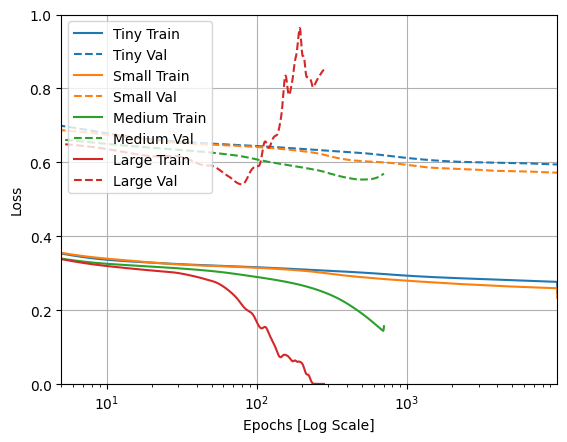

In [98]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.0, 1])
plt.xlabel("Epochs [Log Scale]")

## Strategies to prevent overfitting

Before getting into the content of this section copying the training logs from the "Tiny" model, to use as a baseline for comparison.

In [104]:
shutil.rmtree(logdir/'regularizers/Tiny', ignore_errors=True)
shutil.copytree(logdir/'sizes/Tiny', logdir/'regularizers/Tiny')

WindowsPath('C:/Users/mehri/AppData/Local/Temp/tmpuek5uc5l/tensorboard_logs/regularizers/Tiny')

In [105]:
regularizer_histories = {}
regularizer_histories['Tiny'] = size_histories['Tiny']

### Weight regularization

a common way to mitigate overfitting is to put constraints on the complexity of a network by forcing its weights only to take small values, which makes the distribution of weight values more "regular".

* **L1 regularization**, where the cost added is proportional to the absolute value of the weights coefficients (i.e. to what is called the "L1 norm" of the weights).

* **L2 regularization**, where the cost added is proportional to the square of the value of the weights coefficients (i.e. to what is called the squared "L2 norm" of the weights).

In [106]:
l2_regulirized_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001),
                 input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1)
])

regularizer_histories['l2'] = compile_and_fit(l2_regulirized_model, "regularizers/l2")

c:\Users\mehri\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_28 (Dense)                │ (None, 512)            │        14,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 803,329 (3.06 MB)

 Trainable params: 803,329 (3.06 MB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, accuracy:0.5137,  binary_crossentropy:0.8205,  loss:2.3432,  val_accuracy:0.4850,  val_binary_crossentropy:0.6817,  val_loss:2.1314,  
..

c:\Users\mehri\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


..................................................................................................
Epoch: 100, accuracy:0.6401,  binary_crossentropy:0.6135,  loss:0.6409,  val_accuracy:0.6300,  val_binary_crossentropy:0.6195,  val_loss:0.6466,  
....................................................................................................
Epoch: 200, accuracy:0.6656,  binary_crossentropy:0.5954,  loss:0.6229,  val_accuracy:0.6530,  val_binary_crossentropy:0.6100,  val_loss:0.6375,  
....................................................................................................
Epoch: 300, accuracy:0.6746,  binary_crossentropy:0.5859,  loss:0.6128,  val_accuracy:0.6600,  val_binary_crossentropy:0.6037,  val_loss:0.6306,  
....................................................................................................
Epoch: 400, accuracy:0.6781,  binary_crossentropy:0.5791,  loss:0.6055,  val_accuracy:0.6680,  val_binary_crossentropy:0.6018,  val_loss:0.6279,  
..........

### Dropout

The intuitive explanation for dropout is that because individual nodes in the network cannot rely on the output of the others, each node must output features that are useful on their own.

Dropout, applied to a layer, consists of randomly "dropping out" (i.e. set to zero) a number of output features of the layer during training

The `dropout rate` is the fraction of the features that are being zeroed-out; it is usually set between **0.2** and **0.5**.

**At test time, no units are dropped out**

Add two dropout layers to your network to check how well they do at reducing overfitting:

In [107]:
dropout_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['dropout'] = compile_and_fit(dropout_model, "regularizers/dropout")

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_33 (Dense)                │ (None, 512)            │        14,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 803,329 (3.06 MB)

 Trainable params: 803,329 (3.06 MB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, accuracy:0.5023,  binary_crossentropy:0.8036,  loss:0.8036,  val_accuracy:0.5150,  val_binary_crossentropy:0.6744,  val_loss:0.6744,  
....................................................................................................
Epoch: 100, accuracy:0.6344,  binary_crossentropy:0.6147,  loss:0.6147,  val_accuracy:0.6480,  val_binary_crossentropy:0.6085,  val_loss:0.6085,  
....................................................................................................
Epoch: 200, accuracy:0.6668,  binary_crossentropy:0.5884,  loss:0.5884,  val_accuracy:0.6770,  val_binary_crossentropy:0.5860,  val_loss:0.5860,  
....................................................................................................
Epoch: 300, accuracy:0.6794,  binary_crossentropy:0.5688,  loss:0.5688,  val_accuracy:0.6770,  val_binary_crossentropy:0.5645,  val_loss:0.5645,  
....................................................................................................
Epoch: 40

(0.0, 0.7)

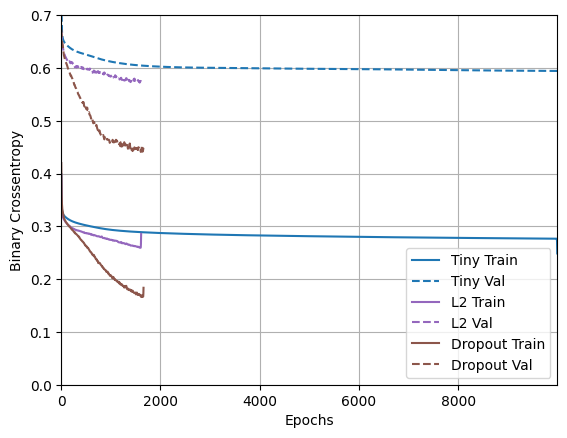

In [110]:
plotter.plot(regularizer_histories)
plt.ylim([0.0, 0.7])

## Conclusion

here are the most common ways to prevent overfitting in neural networks:

* Get more training data.
* Reduce the capacity of the network.
* Add weight regularization.
* Add dropout.